# Framework to Spot-Check Machine Learning Algorithms in Python (Regression / Classification)

References: ["How to Develop a Framework to Spot-Check Machine Learning Algorithms in Python"](https://machinelearningmastery.com/spot-check-machine-learning-algorithms-in-python/)

Spot-checking algorithms is a technique in applied machine learning designed to quickly and objectively provide a first set of results on a new predictive modeling problem.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Spot-Checking for Classification

Defined 53 models
>logistic: 0.848 (+/-0.034)
>ridge-0.1: 0.845 (+/-0.038)
>ridge-0.2: 0.845 (+/-0.038)
>ridge-0.3: 0.845 (+/-0.038)
>ridge-0.4: 0.845 (+/-0.038)
>ridge-0.5: 0.845 (+/-0.038)
>ridge-0.6: 0.845 (+/-0.038)
>ridge-0.7: 0.846 (+/-0.039)
>ridge-0.8: 0.847 (+/-0.039)
>ridge-0.9: 0.847 (+/-0.039)
>ridge-1.0: 0.847 (+/-0.039)
>sgd: 0.796 (+/-0.056)
>pa: 0.736 (+/-0.067)
>knn-1: 0.726 (+/-0.040)
>knn-2: 0.688 (+/-0.026)
>knn-3: 0.741 (+/-0.036)
>knn-4: 0.726 (+/-0.027)
>knn-5: 0.768 (+/-0.035)
>knn-6: 0.755 (+/-0.028)
>knn-7: 0.769 (+/-0.038)
>knn-8: 0.761 (+/-0.045)
>knn-9: 0.772 (+/-0.042)
>knn-10: 0.765 (+/-0.040)
>knn-11: 0.781 (+/-0.043)
>knn-12: 0.780 (+/-0.045)
>knn-13: 0.789 (+/-0.036)
>knn-14: 0.788 (+/-0.036)
>knn-15: 0.800 (+/-0.045)
>knn-16: 0.791 (+/-0.039)
>knn-17: 0.799 (+/-0.027)
>knn-18: 0.796 (+/-0.031)
>knn-19: 0.799 (+/-0.033)
>knn-20: 0.801 (+/-0.035)
>cart: 0.801 (+/-0.036)
>extra: 0.739 (+/-0.031)
>svml: 0.841 (+/-0.035)
>svmp: 0.810 (+/-0.048)
>svmr0.1: 0

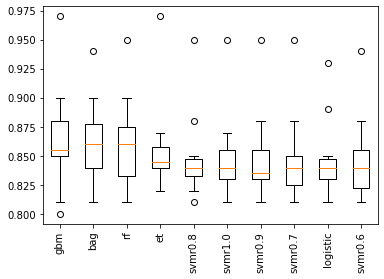

In [22]:
# binary classification spot check script
import warnings
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

# load the dataset, returns X and y elements
def load_dataset():
	return make_classification(n_samples=1000, n_classes=2, random_state=1)

# create a dict of standard models to evaluate {name:object}
def define_models(models=dict()):
	# linear models
	models['logistic'] = LogisticRegression()
	alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for a in alpha:
		models['ridge-'+str(a)] = RidgeClassifier(alpha=a)
	models['sgd'] = SGDClassifier(max_iter=1000, tol=1e-3)
	models['pa'] = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3)
	# non-linear models
	n_neighbors = range(1, 21)
	for k in n_neighbors:
		models['knn-'+str(k)] = KNeighborsClassifier(n_neighbors=k)
	models['cart'] = DecisionTreeClassifier()
	models['extra'] = ExtraTreeClassifier()
	models['svml'] = SVC(kernel='linear')
	models['svmp'] = SVC(kernel='poly')
	c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for c in c_values:
		models['svmr'+str(c)] = SVC(C=c)
	models['bayes'] = GaussianNB()
	# ensemble models
	n_trees = 100
	models['ada'] = AdaBoostClassifier(n_estimators=n_trees)
	models['bag'] = BaggingClassifier(n_estimators=n_trees)
	models['rf'] = RandomForestClassifier(n_estimators=n_trees)
	models['et'] = ExtraTreesClassifier(n_estimators=n_trees)
	models['gbm'] = GradientBoostingClassifier(n_estimators=n_trees)
	print('Defined %d models' % len(models))
	return models

# create a feature preparation pipeline for a model
def make_pipeline(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

# evaluate a single model
def evaluate_model(X, y, model, folds, metric):
	# create the pipeline
	pipeline = make_pipeline(model)
	# evaluate model
	scores = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
	return scores

# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, folds, metric):
	scores = None
	try:
		with warnings.catch_warnings():
			warnings.filterwarnings("ignore")
			scores = evaluate_model(X, y, model, folds, metric)
	except:
		scores = None
	return scores

# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, folds=10, metric='f1_macro'):
	results = dict()
	for name, model in models.items():
		# evaluate the model
		scores = robust_evaluate_model(X, y, model, folds, metric)
		# show process
		if scores is not None:
			# store a result
			results[name] = scores
			mean_score, std_score = mean(scores), std(scores)
			print('>%s: %.3f (+/-%.3f)' % (name, mean_score, std_score))
		else:
			print('>%s: error' % name)
	return results

# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
	# check for no results
	if len(results) == 0:
		print('no results')
		return
	# determine how many results to summarize
	n = min(top_n, len(results))
	# create a list of (name, mean(scores)) tuples
	mean_scores = [(k,mean(v)) for k,v in results.items()]
	# sort tuples by mean score
	mean_scores = sorted(mean_scores, key=lambda x: x[1])
	# reverse for descending order (e.g. for accuracy)
	if maximize:
		mean_scores = list(reversed(mean_scores))
	# retrieve the top n for summarization
	names = [x[0] for x in mean_scores[:n]]
	scores = [results[x[0]] for x in mean_scores[:n]]
	# print the top n
	print()
	for i in range(n):
		name = names[i]
		mean_score, std_score = mean(results[name]), std(results[name])
		print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
	# boxplot for the top n
	pyplot.boxplot(scores, labels=names)
	_, labels = pyplot.xticks()
	pyplot.setp(labels, rotation=90)
	pyplot.savefig('spotcheck.png')

# load dataset
X, y = load_dataset()
# get model list
models = define_models()
# evaluate models
results = evaluate_models(X, y, models)
# summarize results
summarize_results(results)

## Spot-Checking for Regression

Defined 190 models
>lr: -0.011 (+/-0.001)
>lasso-0.0: -0.011 (+/-0.001)
>lasso-0.1: -4.756 (+/-0.808)
>lasso-0.2: -18.996 (+/-3.268)
>lasso-0.3: -42.730 (+/-7.379)
>lasso-0.4: -75.957 (+/-13.144)
>lasso-0.5: -118.679 (+/-20.561)
>lasso-0.6: -170.895 (+/-29.631)
>lasso-0.7: -232.605 (+/-40.354)
>lasso-0.8: -303.810 (+/-52.729)
>lasso-0.9: -384.509 (+/-66.757)
>lasso-1.0: -474.701 (+/-82.438)
>ridge-0.0: -0.011 (+/-0.001)
>ridge-0.1: -0.902 (+/-0.167)
>ridge-0.2: -3.534 (+/-0.668)
>ridge-0.3: -7.847 (+/-1.492)
>ridge-0.4: -13.780 (+/-2.628)
>ridge-0.5: -21.277 (+/-4.064)
>ridge-0.6: -30.283 (+/-5.788)
>ridge-0.7: -40.744 (+/-7.790)
>ridge-0.8: -52.610 (+/-10.059)
>ridge-0.9: -65.831 (+/-12.586)
>ridge-1.0: -80.359 (+/-15.361)
>en-0.0-0.0: -0.011 (+/-0.001)
>en-0.0-0.1: -0.011 (+/-0.001)
>en-0.0-0.2: -0.011 (+/-0.001)
>en-0.0-0.3: -0.011 (+/-0.001)
>en-0.0-0.4: -0.011 (+/-0.001)
>en-0.0-0.5: -0.011 (+/-0.001)
>en-0.0-0.6: -0.011 (+/-0.001)
>en-0.0-0.7: -0.011 (+/-0.001)
>en-0.0-0.8: -0.01

/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive

>en-1.0-0.0: -27695.152 (+/-4685.171)
>en-1.0-0.1: -27575.112 (+/-4665.114)
>en-1.0-0.2: -27427.092 (+/-4639.759)
>en-1.0-0.3: -27239.294 (+/-4608.249)
>en-1.0-0.4: -26992.542 (+/-4567.298)
>en-1.0-0.5: -26653.630 (+/-4511.312)
>en-1.0-0.6: -26158.725 (+/-4429.369)
>en-1.0-0.7: -25368.138 (+/-4298.861)
>en-1.0-0.8: -23904.654 (+/-4057.544)
>en-1.0-0.9: -20267.558 (+/-3454.520)
>en-1.0-1.0: -474.701 (+/-82.438)
>huber: -0.011 (+/-0.002)
>lars: -0.011 (+/-0.001)
>llars: -6818.447 (+/-1183.737)
>pa: -0.019 (+/-0.010)
>ranscac: -0.011 (+/-0.001)
>sgd: -2148.415 (+/-738.441)
>theil: -0.011 (+/-0.002)
>knn-1: -30869.042 (+/-3905.159)
>knn-2: -23313.703 (+/-4263.314)
>knn-3: -21308.250 (+/-3942.296)
>knn-4: -19989.521 (+/-3146.635)
>knn-5: -19575.096 (+/-3217.275)
>knn-6: -19077.575 (+/-2944.185)
>knn-7: -18611.225 (+/-3059.335)
>knn-8: -18616.046 (+/-2952.398)
>knn-9: -18543.176 (+/-2781.085)
>knn-10: -18480.473 (+/-2848.115)
>knn-11: -18313.496 (+/-2777.947)
>knn-12: -18455.572 (+/-2880.450

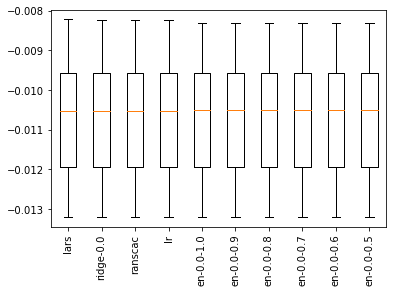

In [23]:
# regression spot check script
import warnings
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

# load the dataset, returns X and y elements
def load_dataset():
	return make_regression(n_samples=1000, n_features=50, noise=0.1, random_state=1)

# create a dict of standard models to evaluate {name:object}
def get_models(models=dict()):
	# linear models
	models['lr'] = LinearRegression()
	alpha = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for a in alpha:
		models['lasso-'+str(a)] = Lasso(alpha=a)
	for a in alpha:
		models['ridge-'+str(a)] = Ridge(alpha=a)
	for a1 in alpha:
		for a2 in alpha:
			name = 'en-' + str(a1) + '-' + str(a2)
			models[name] = ElasticNet(a1, a2)
	models['huber'] = HuberRegressor()
	models['lars'] = Lars()
	models['llars'] = LassoLars()
	models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
	models['ranscac'] = RANSACRegressor()
	models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
	models['theil'] = TheilSenRegressor()
	# non-linear models
	n_neighbors = range(1, 21)
	for k in n_neighbors:
		models['knn-'+str(k)] = KNeighborsRegressor(n_neighbors=k)
	models['cart'] = DecisionTreeRegressor()
	models['extra'] = ExtraTreeRegressor()
	models['svml'] = SVR(kernel='linear')
	models['svmp'] = SVR(kernel='poly')
	c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for c in c_values:
		models['svmr'+str(c)] = SVR(C=c)
	# ensemble models
	n_trees = 100
	models['ada'] = AdaBoostRegressor(n_estimators=n_trees)
	models['bag'] = BaggingRegressor(n_estimators=n_trees)
	models['rf'] = RandomForestRegressor(n_estimators=n_trees)
	models['et'] = ExtraTreesRegressor(n_estimators=n_trees)
	models['gbm'] = GradientBoostingRegressor(n_estimators=n_trees)
	print('Defined %d models' % len(models))
	return models

# create a feature preparation pipeline for a model
def make_pipeline(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

# evaluate a single model
def evaluate_model(X, y, model, folds, metric):
	# create the pipeline
	pipeline = make_pipeline(model)
	# evaluate model
	scores = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
	return scores

# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, folds, metric):
	scores = None
	try:
		with warnings.catch_warnings():
			warnings.filterwarnings("ignore")
			scores = evaluate_model(X, y, model, folds, metric)
	except:
		scores = None
	return scores

# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, folds=10, metric='neg_root_mean_squared_error'):
	results = dict()
	for name, model in models.items():
		# evaluate the model
		scores = robust_evaluate_model(X, y, model, folds, metric)
		# show process
		if scores is not None:
			# store a result
			results[name] = scores
			mean_score, std_score = mean(scores), std(scores)
			print('>%s: %.3f (+/-%.3f)' % (name, mean_score, std_score))
		else:
			print('>%s: error' % name)
	return results

# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
	# check for no results
	if len(results) == 0:
		print('no results')
		return
	# determine how many results to summarize
	n = min(top_n, len(results))
	# create a list of (name, mean(scores)) tuples
	mean_scores = [(k,mean(v)) for k,v in results.items()]
	# sort tuples by mean score
	mean_scores = sorted(mean_scores, key=lambda x: x[1])
	# reverse for descending order (e.g. for accuracy)
	if maximize:
		mean_scores = list(reversed(mean_scores))
	# retrieve the top n for summarization
	names = [x[0] for x in mean_scores[:n]]
	scores = [results[x[0]] for x in mean_scores[:n]]
	# print the top n
	print()
	for i in range(n):
		name = names[i]
		mean_score, std_score = mean(results[name]), std(results[name])
		print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
	# boxplot for the top n
	pyplot.boxplot(scores, labels=names)
	_, labels = pyplot.xticks()
	pyplot.setp(labels, rotation=90)
	pyplot.savefig('spotcheck.png')

# load dataset
X, y = load_dataset()
# get model list
models = get_models()
# evaluate models
results = evaluate_models(X, y, models)
# summarize results
summarize_results(results)

## Framework Extension: Course Grid Search for Gradient Boosting

In [25]:
# define gradient boosting models (for Classification)
def define_gbm_models(models=dict(), use_xgb=True):
	# define config ranges
	rates = [0.001, 0.01, 0.1]
	trees = [50, 100]
	ss = [0.5, 0.7, 1.0]
	depth = [3, 7, 9]
	# add configurations
	for l in rates:
		for e in trees:
			for s in ss:
				for d in depth:
					cfg = [l, e, s, d]
					if use_xgb:
						name = 'xgb-' + str(cfg)
						models[name] = XGBClassifier(learning_rate=l, n_estimators=e, subsample=s, max_depth=d)
					else:
						name = 'gbm-' + str(cfg)
						models[name] = GradientBoostingClassifier(learning_rate=l, n_estimators=e, subsample=s, max_depth=d)
	print('Defined %d models' % len(models))
	return models


# define gradient boosting models (for Regression)
def get_gbm_models(models=dict(), use_xgb=True):
	# define config ranges
	rates = [0.001, 0.01, 0.1]
	trees = [50, 100]
	ss = [0.5, 0.7, 1.0]
	depth = [3, 7, 9]
	# add configurations
	for l in rates:
		for e in trees:
			for s in ss:
				for d in depth:
					cfg = [l, e, s, d]
					if use_xgb:
						name = 'xgb-' + str(cfg)
						models[name] = XGBRegressor(learning_rate=l, n_estimators=e, subsample=s, max_depth=d)
					else:
						name = 'gbm-' + str(cfg)
						models[name] = GradientBoostingXGBRegressor(learning_rate=l, n_estimators=e, subsample=s, max_depth=d)
	print('Defined %d models' % len(models))
	return models

Defined 53 models
Defined 107 models
>logistic: 0.848 (+/-0.034)
>ridge-0.1: 0.845 (+/-0.038)
>ridge-0.2: 0.845 (+/-0.038)
>ridge-0.3: 0.845 (+/-0.038)
>ridge-0.4: 0.845 (+/-0.038)
>ridge-0.5: 0.845 (+/-0.038)
>ridge-0.6: 0.845 (+/-0.038)
>ridge-0.7: 0.846 (+/-0.039)
>ridge-0.8: 0.847 (+/-0.039)
>ridge-0.9: 0.847 (+/-0.039)
>ridge-1.0: 0.847 (+/-0.039)
>sgd: 0.825 (+/-0.049)
>pa: 0.742 (+/-0.102)
>knn-1: 0.726 (+/-0.040)
>knn-2: 0.688 (+/-0.026)
>knn-3: 0.741 (+/-0.036)
>knn-4: 0.726 (+/-0.027)
>knn-5: 0.768 (+/-0.035)
>knn-6: 0.755 (+/-0.028)
>knn-7: 0.769 (+/-0.038)
>knn-8: 0.761 (+/-0.045)
>knn-9: 0.772 (+/-0.042)
>knn-10: 0.765 (+/-0.040)
>knn-11: 0.781 (+/-0.043)
>knn-12: 0.780 (+/-0.045)
>knn-13: 0.789 (+/-0.036)
>knn-14: 0.788 (+/-0.036)
>knn-15: 0.800 (+/-0.045)
>knn-16: 0.791 (+/-0.039)
>knn-17: 0.799 (+/-0.027)
>knn-18: 0.796 (+/-0.031)
>knn-19: 0.799 (+/-0.033)
>knn-20: 0.801 (+/-0.035)
>cart: 0.793 (+/-0.041)
>extra: 0.751 (+/-0.029)
>svml: 0.841 (+/-0.035)
>svmp: 0.810 (+/

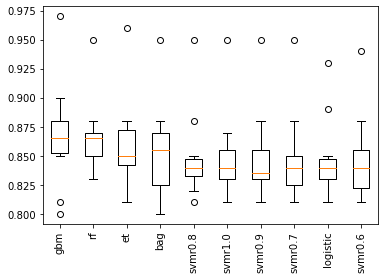

In [26]:
# binary classification spot check script
import warnings
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# load the dataset, returns X and y elements
def load_dataset():
	return make_classification(n_samples=1000, n_classes=2, random_state=1)

# create a dict of standard models to evaluate {name:object}
def define_models(models=dict()):
	# linear models
	models['logistic'] = LogisticRegression()
	alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for a in alpha:
		models['ridge-'+str(a)] = RidgeClassifier(alpha=a)
	models['sgd'] = SGDClassifier(max_iter=1000, tol=1e-3)
	models['pa'] = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3)
	# non-linear models
	n_neighbors = range(1, 21)
	for k in n_neighbors:
		models['knn-'+str(k)] = KNeighborsClassifier(n_neighbors=k)
	models['cart'] = DecisionTreeClassifier()
	models['extra'] = ExtraTreeClassifier()
	models['svml'] = SVC(kernel='linear')
	models['svmp'] = SVC(kernel='poly')
	c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for c in c_values:
		models['svmr'+str(c)] = SVC(C=c)
	models['bayes'] = GaussianNB()
	# ensemble models
	n_trees = 100
	models['ada'] = AdaBoostClassifier(n_estimators=n_trees)
	models['bag'] = BaggingClassifier(n_estimators=n_trees)
	models['rf'] = RandomForestClassifier(n_estimators=n_trees)
	models['et'] = ExtraTreesClassifier(n_estimators=n_trees)
	models['gbm'] = GradientBoostingClassifier(n_estimators=n_trees)
	print('Defined %d models' % len(models))
	return models

# define gradient boosting models
def define_gbm_models(models=dict(), use_xgb=True):
	# define config ranges
	rates = [0.001, 0.01, 0.1]
	trees = [50, 100]
	ss = [0.5, 0.7, 1.0]
	depth = [3, 7, 9]
	# add configurations
	for l in rates:
		for e in trees:
			for s in ss:
				for d in depth:
					cfg = [l, e, s, d]
					if use_xgb:
						name = 'xgb-' + str(cfg)
						models[name] = XGBClassifier(learning_rate=l, n_estimators=e, subsample=s, max_depth=d)
					else:
						name = 'gbm-' + str(cfg)
						models[name] = GradientBoostingClassifier(learning_rate=l, n_estimators=e, subsample=s, max_depth=d)
	print('Defined %d models' % len(models))
	return models

# create a feature preparation pipeline for a model
def make_pipeline(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

# evaluate a single model
def evaluate_model(X, y, model, folds, metric):
	# create the pipeline
	pipeline = make_pipeline(model)
	# evaluate model
	scores = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
	return scores

# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, folds, metric):
	scores = None
	try:
		with warnings.catch_warnings():
			warnings.filterwarnings("ignore")
			scores = evaluate_model(X, y, model, folds, metric)
	except:
		scores = None
	return scores

# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, folds=10, metric='f1_macro'):
	results = dict()
	for name, model in models.items():
		# evaluate the model
		scores = robust_evaluate_model(X, y, model, folds, metric)
		# show process
		if scores is not None:
			# store a result
			results[name] = scores
			mean_score, std_score = mean(scores), std(scores)
			print('>%s: %.3f (+/-%.3f)' % (name, mean_score, std_score))
		else:
			print('>%s: error' % name)
	return results

# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
	# check for no results
	if len(results) == 0:
		print('no results')
		return
	# determine how many results to summarize
	n = min(top_n, len(results))
	# create a list of (name, mean(scores)) tuples
	mean_scores = [(k,mean(v)) for k,v in results.items()]
	# sort tuples by mean score
	mean_scores = sorted(mean_scores, key=lambda x: x[1])
	# reverse for descending order (e.g. for accuracy)
	if maximize:
		mean_scores = list(reversed(mean_scores))
	# retrieve the top n for summarization
	names = [x[0] for x in mean_scores[:n]]
	scores = [results[x[0]] for x in mean_scores[:n]]
	# print the top n
	print()
	for i in range(n):
		name = names[i]
		mean_score, std_score = mean(results[name]), std(results[name])
		print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
	# boxplot for the top n
	pyplot.boxplot(scores, labels=names)
	_, labels = pyplot.xticks()
	pyplot.setp(labels, rotation=90)
	pyplot.savefig('spotcheck.png')

# load dataset
X, y = load_dataset()
# get model list
models = define_models()
# add gbm models
models = define_gbm_models(models)
# evaluate models
results = evaluate_models(X, y, models)
# summarize results
summarize_results(results)

## Framework Extension: Repeated Evaluations

The above results also highlight the noisy nature of the evaluations, e.g. the results of extra trees in this run are different from the run above (0.858 vs 0.869).

We are using k-fold cross-validation to produce a population of scores, but the population is small and the calculated mean will be noisy.

We can update the evaluate_model() function to repeat the evaluation of a given model n-times, with a different split of the data each time, then return all scores. For example, three repeats of 10-fold cross-validation will result in 30 scores from each to calculate a mean performance of a model.

In [27]:
# evaluate a single model
def evaluate_model(X, y, model, folds, repeats, metric):
	# create the pipeline
	pipeline = make_pipeline(model)
	# evaluate model
	scores = list()
	# repeat model evaluation n times
	for _ in range(repeats):
		# perform run
		scores_r = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
		# add scores to list
		scores += scores_r.tolist()
	return scores

Defined 53 models
>logistic: 0.848 (+/-0.034)
>ridge-0.1: 0.845 (+/-0.038)
>ridge-0.2: 0.845 (+/-0.038)
>ridge-0.3: 0.845 (+/-0.038)
>ridge-0.4: 0.845 (+/-0.038)
>ridge-0.5: 0.845 (+/-0.038)
>ridge-0.6: 0.845 (+/-0.038)
>ridge-0.7: 0.846 (+/-0.039)
>ridge-0.8: 0.847 (+/-0.039)
>ridge-0.9: 0.847 (+/-0.039)
>ridge-1.0: 0.847 (+/-0.039)
>sgd: 0.818 (+/-0.053)
>pa: 0.784 (+/-0.074)
>knn-1: 0.726 (+/-0.040)
>knn-2: 0.688 (+/-0.026)
>knn-3: 0.741 (+/-0.036)
>knn-4: 0.726 (+/-0.027)
>knn-5: 0.768 (+/-0.035)
>knn-6: 0.755 (+/-0.028)
>knn-7: 0.769 (+/-0.038)
>knn-8: 0.761 (+/-0.045)
>knn-9: 0.772 (+/-0.042)
>knn-10: 0.765 (+/-0.040)
>knn-11: 0.781 (+/-0.043)
>knn-12: 0.780 (+/-0.045)
>knn-13: 0.789 (+/-0.036)
>knn-14: 0.788 (+/-0.036)
>knn-15: 0.800 (+/-0.045)
>knn-16: 0.791 (+/-0.039)
>knn-17: 0.799 (+/-0.027)
>knn-18: 0.796 (+/-0.031)
>knn-19: 0.799 (+/-0.033)
>knn-20: 0.801 (+/-0.035)
>cart: 0.793 (+/-0.041)
>extra: 0.731 (+/-0.049)
>svml: 0.841 (+/-0.035)
>svmp: 0.810 (+/-0.048)
>svmr0.1: 0

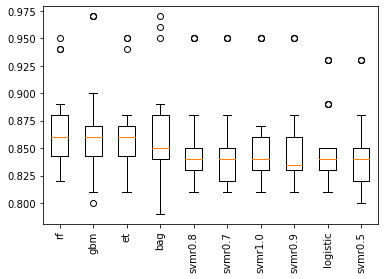

In [28]:
# binary classification spot check script
import warnings
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

# load the dataset, returns X and y elements
def load_dataset():
	return make_classification(n_samples=1000, n_classes=2, random_state=1)

# create a dict of standard models to evaluate {name:object}
def define_models(models=dict()):
	# linear models
	models['logistic'] = LogisticRegression()
	alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for a in alpha:
		models['ridge-'+str(a)] = RidgeClassifier(alpha=a)
	models['sgd'] = SGDClassifier(max_iter=1000, tol=1e-3)
	models['pa'] = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3)
	# non-linear models
	n_neighbors = range(1, 21)
	for k in n_neighbors:
		models['knn-'+str(k)] = KNeighborsClassifier(n_neighbors=k)
	models['cart'] = DecisionTreeClassifier()
	models['extra'] = ExtraTreeClassifier()
	models['svml'] = SVC(kernel='linear')
	models['svmp'] = SVC(kernel='poly')
	c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for c in c_values:
		models['svmr'+str(c)] = SVC(C=c)
	models['bayes'] = GaussianNB()
	# ensemble models
	n_trees = 100
	models['ada'] = AdaBoostClassifier(n_estimators=n_trees)
	models['bag'] = BaggingClassifier(n_estimators=n_trees)
	models['rf'] = RandomForestClassifier(n_estimators=n_trees)
	models['et'] = ExtraTreesClassifier(n_estimators=n_trees)
	models['gbm'] = GradientBoostingClassifier(n_estimators=n_trees)
	print('Defined %d models' % len(models))
	return models

# create a feature preparation pipeline for a model
def make_pipeline(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

# evaluate a single model
def evaluate_model(X, y, model, folds, repeats, metric):
	# create the pipeline
	pipeline = make_pipeline(model)
	# evaluate model
	scores = list()
	# repeat model evaluation n times
	for _ in range(repeats):
		# perform run
		scores_r = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
		# add scores to list
		scores += scores_r.tolist()
	return scores

# evaluate a model and try to trap errors and hide warnings
def robust_evaluate_model(X, y, model, folds, repeats, metric):
	scores = None
	try:
		with warnings.catch_warnings():
			warnings.filterwarnings("ignore")
			scores = evaluate_model(X, y, model, folds, repeats, metric)
	except:
		scores = None
	return scores

# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, folds=10, repeats=3, metric='f1_macro'):
	results = dict()
	for name, model in models.items():
		# evaluate the model
		scores = robust_evaluate_model(X, y, model, folds, repeats, metric)
		# show process
		if scores is not None:
			# store a result
			results[name] = scores
			mean_score, std_score = mean(scores), std(scores)
			print('>%s: %.3f (+/-%.3f)' % (name, mean_score, std_score))
		else:
			print('>%s: error' % name)
	return results

# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
	# check for no results
	if len(results) == 0:
		print('no results')
		return
	# determine how many results to summarize
	n = min(top_n, len(results))
	# create a list of (name, mean(scores)) tuples
	mean_scores = [(k,mean(v)) for k,v in results.items()]
	# sort tuples by mean score
	mean_scores = sorted(mean_scores, key=lambda x: x[1])
	# reverse for descending order (e.g. for accuracy)
	if maximize:
		mean_scores = list(reversed(mean_scores))
	# retrieve the top n for summarization
	names = [x[0] for x in mean_scores[:n]]
	scores = [results[x[0]] for x in mean_scores[:n]]
	# print the top n
	print()
	for i in range(n):
		name = names[i]
		mean_score, std_score = mean(results[name]), std(results[name])
		print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
	# boxplot for the top n
	pyplot.boxplot(scores, labels=names)
	_, labels = pyplot.xticks()
	pyplot.setp(labels, rotation=90)
	pyplot.savefig('spotcheck.png')

# load dataset
X, y = load_dataset()
# get model list
models = define_models()
# evaluate models
results = evaluate_models(X, y, models)
# summarize results
summarize_results(results)

## Framework Extension: Varied Input data preprocessing

I am a big fan of avoiding assumptions and recommendations for data representations prior to fitting models.

Instead, I like to also spot-check multiple representations and transforms of input data, which I refer to as views.

One way to do this is to update the evaluate_models() function so that we can provide a list of make_pipeline() functions that can be used for each defined model.

In [29]:
# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, pipe_funcs, folds=10, metric='f1_macro'):
	results = dict()
	for name, model in models.items():
		# evaluate model under each preparation function
		for i in range(len(pipe_funcs)):
			# evaluate the model
			scores = robust_evaluate_model(X, y, model, folds, metric, pipe_funcs[i])
			# update name
			run_name = str(i) + name
			# show process
			if scores is not None:
				# store a result
				results[run_name] = scores
				mean_score, std_score = mean(scores), std(scores)
				print('>%s: %.3f (+/-%.3f)' % (run_name, mean_score, std_score))
			else:
				print('>%s: error' % run_name)
	return results

The chosen pipeline function can then be passed along down to the robust_evaluate_model() function and to the evaluate_model() function where it can be used.

We can then define a bunch of different pipeline functions; for example:

In [30]:
# no transforms pipeline
def pipeline_none(model):
	return model

# standardize transform pipeline
def pipeline_standardize(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

# normalize transform pipeline
def pipeline_normalize(model):
	steps = list()
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

# standardize and normalize pipeline
def pipeline_std_norm(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

Defined 53 models
>0logistic: 0.844 (+/-0.043)
>1logistic: 0.844 (+/-0.043)
>2logistic: 0.848 (+/-0.034)
>3logistic: 0.848 (+/-0.034)
>0ridge-0.1: 0.845 (+/-0.038)
>1ridge-0.1: 0.845 (+/-0.038)
>2ridge-0.1: 0.845 (+/-0.038)
>3ridge-0.1: 0.845 (+/-0.038)
>0ridge-0.2: 0.845 (+/-0.038)
>1ridge-0.2: 0.845 (+/-0.038)
>2ridge-0.2: 0.845 (+/-0.038)
>3ridge-0.2: 0.845 (+/-0.038)
>0ridge-0.3: 0.845 (+/-0.038)
>1ridge-0.3: 0.845 (+/-0.038)
>2ridge-0.3: 0.845 (+/-0.038)
>3ridge-0.3: 0.845 (+/-0.038)
>0ridge-0.4: 0.845 (+/-0.038)
>1ridge-0.4: 0.845 (+/-0.038)
>2ridge-0.4: 0.845 (+/-0.038)
>3ridge-0.4: 0.845 (+/-0.038)
>0ridge-0.5: 0.845 (+/-0.038)
>1ridge-0.5: 0.845 (+/-0.038)
>2ridge-0.5: 0.845 (+/-0.038)
>3ridge-0.5: 0.845 (+/-0.038)
>0ridge-0.6: 0.845 (+/-0.038)
>1ridge-0.6: 0.845 (+/-0.038)
>2ridge-0.6: 0.845 (+/-0.038)
>3ridge-0.6: 0.845 (+/-0.038)
>0ridge-0.7: 0.845 (+/-0.038)
>1ridge-0.7: 0.845 (+/-0.038)
>2ridge-0.7: 0.846 (+/-0.039)
>3ridge-0.7: 0.846 (+/-0.039)
>0ridge-0.8: 0.845 (+/-0.0

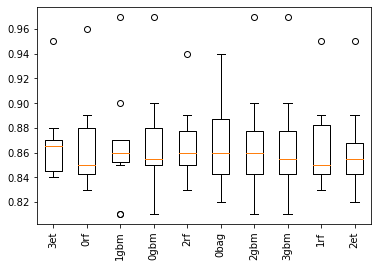

In [9]:
# binary classification spot check script
import warnings
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

# load the dataset, returns X and y elements
def load_dataset():
	return make_classification(n_samples=1000, n_classes=2, random_state=1)

# create a dict of standard models to evaluate {name:object}
def define_models(models=dict()):
	# linear models
	models['logistic'] = LogisticRegression()
	alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for a in alpha:
		models['ridge-'+str(a)] = RidgeClassifier(alpha=a)
	models['sgd'] = SGDClassifier(max_iter=1000, tol=1e-3)
	models['pa'] = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3)
	# non-linear models
	n_neighbors = range(1, 21)
	for k in n_neighbors:
		models['knn-'+str(k)] = KNeighborsClassifier(n_neighbors=k)
	models['cart'] = DecisionTreeClassifier()
	models['extra'] = ExtraTreeClassifier()
	models['svml'] = SVC(kernel='linear')
	models['svmp'] = SVC(kernel='poly')
	c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for c in c_values:
		models['svmr'+str(c)] = SVC(C=c)
	models['bayes'] = GaussianNB()
	# ensemble models
	n_trees = 100
	models['ada'] = AdaBoostClassifier(n_estimators=n_trees)
	models['bag'] = BaggingClassifier(n_estimators=n_trees)
	models['rf'] = RandomForestClassifier(n_estimators=n_trees)
	models['et'] = ExtraTreesClassifier(n_estimators=n_trees)
	models['gbm'] = GradientBoostingClassifier(n_estimators=n_trees)
	print('Defined %d models' % len(models))
	return models

# no transforms pipeline
def pipeline_none(model):
	return model

# standardize transform pipeline
def pipeline_standardize(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

# normalize transform pipeline
def pipeline_normalize(model):
	steps = list()
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

# standardize and normalize pipeline
def pipeline_std_norm(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

# evaluate a single model
def evaluate_model(X, y, model, folds, metric, pipe_func):
	# create the pipeline
	pipeline = pipe_func(model)
	# evaluate model
	scores = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
	return scores

# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, folds, metric, pipe_func):
	scores = None
	try:
		with warnings.catch_warnings():
			warnings.filterwarnings("ignore")
			scores = evaluate_model(X, y, model, folds, metric, pipe_func)
	except:
		scores = None
	return scores

# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, pipe_funcs, folds=10, metric='f1_macro'):
	results = dict()
	for name, model in models.items():
		# evaluate model under each preparation function
		for i in range(len(pipe_funcs)):
			# evaluate the model
			scores = robust_evaluate_model(X, y, model, folds, metric, pipe_funcs[i])
			# update name
			run_name = str(i) + name
			# show process
			if scores is not None:
				# store a result
				results[run_name] = scores
				mean_score, std_score = mean(scores), std(scores)
				print('>%s: %.3f (+/-%.3f)' % (run_name, mean_score, std_score))
			else:
				print('>%s: error' % run_name)
	return results

# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
	# check for no results
	if len(results) == 0:
		print('no results')
		return
	# determine how many results to summarize
	n = min(top_n, len(results))
	# create a list of (name, mean(scores)) tuples
	mean_scores = [(k,mean(v)) for k,v in results.items()]
	# sort tuples by mean score
	mean_scores = sorted(mean_scores, key=lambda x: x[1])
	# reverse for descending order (e.g. for accuracy)
	if maximize:
		mean_scores = list(reversed(mean_scores))
	# retrieve the top n for summarization
	names = [x[0] for x in mean_scores[:n]]
	scores = [results[x[0]] for x in mean_scores[:n]]
	# print the top n
	print()
	for i in range(n):
		name = names[i]
		mean_score, std_score = mean(results[name]), std(results[name])
		print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
	# boxplot for the top n
	pyplot.boxplot(scores, labels=names)
	_, labels = pyplot.xticks()
	pyplot.setp(labels, rotation=90)
	pyplot.savefig('spotcheck.png')

# load dataset
X, y = load_dataset()
# get model list
models = define_models()
# define transform pipelines
pipelines = [pipeline_none, pipeline_standardize, pipeline_normalize, pipeline_std_norm]
# evaluate models
results = evaluate_models(X, y, models, pipelines)
# summarize results
summarize_results(results)

## Spot-Checking for Classification: Iris Example

> NOTE: With all previous extensions.

In [5]:
# binary classification spot check script
import warnings
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# other libraries
import pandas as pd

In [27]:
# load the dataset, returns X and y elements
def load_dataset():
    path = 'https://raw.githubusercontent.com/jmquintana79/Datasets/master/iris.csv'
    df = pd.read_csv(path, header = None)
    col_x = ['x1','x2','x3','x4']; col_y = ['y']
    df.columns = col_x + col_y
    dconverter = {'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}
    df['y'] = df['y'].apply(lambda x: dconverter[x])
    return df[col_x].values, df[col_y[0]].values

# create a dict of standard models to evaluate {name:object}
def define_models(models=dict()):
	# linear models
	models['logistic'] = LogisticRegression()
	alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for a in alpha:
		models['ridge-'+str(a)] = RidgeClassifier(alpha=a)
	models['sgd'] = SGDClassifier(max_iter=1000, tol=1e-3)
	models['pa'] = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3)
	# non-linear models
	n_neighbors = range(1, 21)
	for k in n_neighbors:
		models['knn-'+str(k)] = KNeighborsClassifier(n_neighbors=k)
	models['cart'] = DecisionTreeClassifier()
	models['extra'] = ExtraTreeClassifier()
	models['svml'] = SVC(kernel='linear')
	models['svmp'] = SVC(kernel='poly')
	c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for c in c_values:
		models['svmr'+str(c)] = SVC(C=c)
	models['bayes'] = GaussianNB()
	# ensemble models
	n_trees = 100
	models['ada'] = AdaBoostClassifier(n_estimators=n_trees)
	models['bag'] = BaggingClassifier(n_estimators=n_trees)
	models['rf'] = RandomForestClassifier(n_estimators=n_trees)
	models['et'] = ExtraTreesClassifier(n_estimators=n_trees)
	models['gbm'] = GradientBoostingClassifier(n_estimators=n_trees)
	print('Defined %d models' % len(models))
	return models

# define gradient boosting models
def define_gbm_models(models=dict(), use_xgb=True):
	# define config ranges
	rates = [0.001, 0.01, 0.1]
	trees = [50, 100]
	ss = [0.5, 0.7, 1.0]
	depth = [3, 7, 9]
	# add configurations
	for l in rates[:]:
		for e in trees[:]:
			for s in ss[:]:
				for d in depth[:]:
					cfg = [l, e, s, d]
					if use_xgb:
						name = 'xgb-' + str(cfg)
						models[name] = XGBClassifier(learning_rate=l, n_estimators=e, subsample=s, max_depth=d)
					else:
						name = 'gbm-' + str(cfg)
						models[name] = GradientBoostingClassifier(learning_rate=l, n_estimators=e, subsample=s, max_depth=d)
	print('Defined %d models' % len(models))
	return models


# no transforms pipeline
def pipeline_none(model):
	return model

# standardize transform pipeline
def pipeline_standardize(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

# normalize transform pipeline
def pipeline_normalize(model):
	steps = list()
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

# standardize and normalize pipeline
def pipeline_std_norm(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline


# evaluate a single model
def evaluate_model(X, y, model, folds, repeats, metric, pipe_func):
	# create the pipeline
	pipeline = pipe_func(model)
	# evaluate model
	scores = list()
	# repeat model evaluation n times
	for _ in range(repeats):
		# perform run
		scores_r = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
		# add scores to list
		scores += scores_r.tolist()
	return scores


# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, folds, repeats, metric, pipe_func, verbose = False):
    scores = None
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            scores = evaluate_model(X, y, model, folds, repeats, metric, pipe_func)
    except:
        scores = None
        if verbose:
            print(f'[evaluation] {e}')        
    return scores


# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, pipe_funcs, folds=10, repeats=3, metric='f1_macro'):
	results = dict()
	for name, model in models.items():
		# evaluate model under each preparation function
		for i in range(len(pipe_funcs)):
			# evaluate the model
			scores = robust_evaluate_model(X, y, model, folds, repeats, metric, pipe_funcs[i], verbose = True)
			# update name
			run_name = str(i) + name
			# show process
			if scores is not None:
				# store a result
				results[run_name] = scores
				mean_score, std_score = mean(scores), std(scores)
				print('>%s: %.3f (+/-%.3f)' % (run_name, mean_score, std_score))
			else:
				print('>%s: error' % run_name)
	return results


# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
	# check for no results
	if len(results) == 0:
		print('no results')
		return
	# determine how many results to summarize
	n = min(top_n, len(results))
	# create a list of (name, mean(scores)) tuples
	mean_scores = [(k,mean(v)) for k,v in results.items()]
	# sort tuples by mean score
	mean_scores = sorted(mean_scores, key=lambda x: x[1])
	# reverse for descending order (e.g. for accuracy)
	if maximize:
		mean_scores = list(reversed(mean_scores))
	# retrieve the top n for summarization
	names = [x[0] for x in mean_scores[:n]]
	scores = [results[x[0]] for x in mean_scores[:n]]
	# print the top n
	print()
	for i in range(n):
		name = names[i]
		mean_score, std_score = mean(results[name]), std(results[name])
		print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
	# boxplot for the top n
	pyplot.boxplot(scores, labels=names)
	_, labels = pyplot.xticks()
	pyplot.setp(labels, rotation=90)
	pyplot.savefig('spotcheck.png')


Defined 53 models
Defined 107 models
>0logistic: 0.973 (+/-0.033)
>1logistic: 0.960 (+/-0.062)
>2logistic: 0.917 (+/-0.070)
>3logistic: 0.917 (+/-0.070)
>0ridge-0.1: 0.816 (+/-0.095)
>1ridge-0.1: 0.816 (+/-0.095)
>2ridge-0.1: 0.816 (+/-0.095)
>3ridge-0.1: 0.816 (+/-0.095)
>0ridge-0.2: 0.816 (+/-0.095)
>1ridge-0.2: 0.816 (+/-0.095)
>2ridge-0.2: 0.823 (+/-0.100)
>3ridge-0.2: 0.823 (+/-0.100)
>0ridge-0.3: 0.823 (+/-0.100)
>1ridge-0.3: 0.816 (+/-0.095)
>2ridge-0.3: 0.836 (+/-0.096)
>3ridge-0.3: 0.836 (+/-0.096)
>0ridge-0.4: 0.823 (+/-0.100)
>1ridge-0.4: 0.816 (+/-0.095)
>2ridge-0.4: 0.844 (+/-0.089)
>3ridge-0.4: 0.844 (+/-0.089)
>0ridge-0.5: 0.823 (+/-0.100)
>1ridge-0.5: 0.816 (+/-0.095)
>2ridge-0.5: 0.850 (+/-0.093)
>3ridge-0.5: 0.850 (+/-0.093)
>0ridge-0.6: 0.823 (+/-0.100)
>1ridge-0.6: 0.816 (+/-0.095)
>2ridge-0.6: 0.843 (+/-0.094)
>3ridge-0.6: 0.843 (+/-0.094)
>0ridge-0.7: 0.823 (+/-0.100)
>1ridge-0.7: 0.816 (+/-0.095)
>2ridge-0.7: 0.843 (+/-0.094)
>3ridge-0.7: 0.843 (+/-0.094)
>0ridge

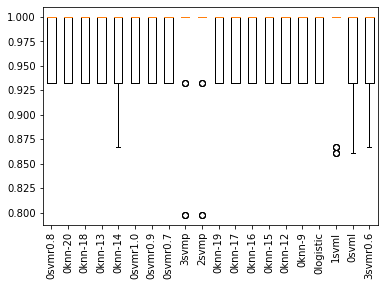

In [28]:
# load dataset
X, y = load_dataset()
# get model list
models = define_models()
# add gbm models
models = define_gbm_models(models, use_xgb=False)
# define transform pipelines
pipelines = [pipeline_none, pipeline_standardize, pipeline_normalize, pipeline_std_norm]
# evaluate models
results = evaluate_models(X, y, models, pipelines)
# summarize results
summarize_results(results, top_n=20)